In [1]:
import pandas as pd
import numpy as np
import pathlib
import pickle
import torch as t
import sys
import matplotlib.pyplot as plt
sys.path.append('C:\\Users\\keren\\Projects\\pytorch-sgns')
import ai2v_model

import numpy as np
from sklearn.manifold import TSNE

In [36]:
H_FOLD = 'C:/Users/keren/Projects/pytorch-sgns'
DATASET = 'goodbooks'

DATA_FOLD = f'corpus/{DATASET}_llo'

AI2V_OUT_FOLD = f'output/{DATASET}_ai2v_llo'
I2V_OUT_FOLD = f'output/{DATASET}_i2v_llo'
BPR_OUT_FOLD = f'output/{DATASET}_bpr_llo'
LGCN_OUT_FOLD = f'output/{DATASET}_lightgcn_llo'
NCF_OUT_FOLD = f'output/{DATASET}_ncf_llo'

AI2V_MODEL_FILE = f'{H_FOLD}/{AI2V_OUT_FOLD}/model.pt'
I2V_MODEL_FILE = f'{H_FOLD}/{I2V_OUT_FOLD}/model.pt'

## Performance on cold start items

In [3]:
ic = pickle.load(pathlib.Path(f'{H_FOLD}/{DATA_FOLD}', 'ic.dat').open('rb'))
idx2item = pickle.load(pathlib.Path(f'{H_FOLD}/{DATA_FOLD}', 'idx2item.dat').open('rb'))

In [55]:
k = 20
metric = 'hr'

In [56]:
# AI2V_MET_FILE = f'{H_FOLD}/{AI2V_OUT_FOLD}/ai2v_netflix_{k}_{metric}.csv'
# I2V_MET_FILE = f'{H_FOLD}/{I2V_OUT_FOLD}/i2v_netflix_{k}_{metric}.csv'

In [57]:
AI2V_MET_FILE = f'{H_FOLD}/{AI2V_OUT_FOLD}/{metric}_{k}.csv'
I2V_MET_FILE = f'{H_FOLD}/{I2V_OUT_FOLD}/{metric}_{k}.csv'

In [58]:
met_col_i2v = f'{metric}_i2v'
met_col_ai2v = f'{metric}_ai2v'

df_i2v = pd.read_csv(I2V_MET_FILE, names=['u_id','i_id',met_col_i2v])
df_ai2v = pd.read_csv(AI2V_MET_FILE, names=['u_id','i_id',met_col_ai2v])

df_i2v['i_name'] = np.array(idx2item)[df_i2v['i_id'].tolist()]
df_ai2v['i_name'] = np.array(idx2item)[df_ai2v['i_id'].tolist()]

df_i2v['item_cnt'] = df_i2v['i_name'].map(ic)
df_ai2v['item_cnt'] = df_ai2v['i_name'].map(ic)

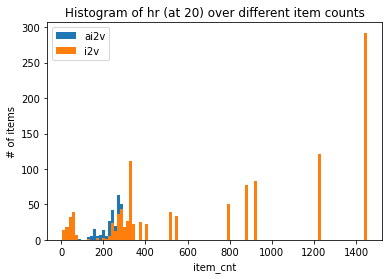

In [59]:
plt.hist(df_ai2v[df_ai2v[met_col_ai2v]==1]['item_cnt'], bins=100, label='ai2v')
plt.hist(df_i2v[df_i2v[met_col_i2v]==1]['item_cnt'], bins=100, label='i2v')
plt.xlabel('item_cnt')
plt.ylabel('# of items')
plt.title(f'Histogram of {metric} (at {k}) over different item counts')
plt.legend()
plt.show()

# TSNE

In [114]:
yahoo = pickle.load(open(f'{H_FOLD}/data/100_songs_train.pkl','rb'))

In [115]:
idx2item = pickle.load(pathlib.Path(f'{H_FOLD}/{DATA_FOLD}', 'idx2item.dat').open('rb'))

In [116]:
idx2item_dict = {i:k for i,k in enumerate(idx2item)}

In [117]:
itemid2singer = {yahoo[1][k]: k.split('#')[1] for k in yahoo[1].keys()}

In [119]:
idx2singer = {k: itemid2singer[int(idx2item_dict[k])] for k in list(idx2item_dict.keys())[:-2]}

In [130]:
colors = {singer:i for i,singer in enumerate(list(set(list(idx2singer.values()))))}

In [145]:
colors

{'Bob_Marley_&_The_Wailers': 0,
 'Toby_Keith': 1,
 'Metallica': 2,
 'Kenny_Chesney': 3,
 'Brad_Paisley': 4}

In [79]:
# Read MovieLens Movies
# datContent = [i.strip().split() for i in open(f'{H_FOLD}/data/movies.dat').readlines()]
# movs_jsons = []
# for mov_t in datContent:
#     mov = mov_t[:-1]
#     m_id, m_name_1 = mov[0].split('::')
#     tag = mov_t[-1]
#     t_id, t_name = tag.split('::')
#     movs_jsons.append({'id': m_id ,'name': m_name_1 + ' ' + ' '.join(mov[1:]), 'tag_id': t_id,  'tag name': t_name})

In [80]:
model = t.load(MODEL_FILE,map_location=t.device('cpu'))

In [81]:
X_embedded = TSNE(n_components=2).fit_transform(np.array(model.ai2v.tvectors.weight.data))

In [144]:
labels = np.array([colors[singer] for singer in idx2singer.values()])

No handles with labels found to put in legend.


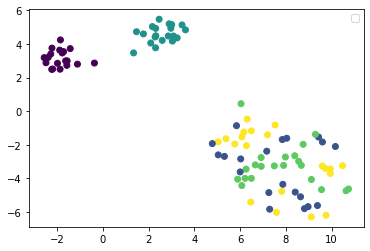

In [153]:
# fig, ax = plt.subplots()
# for clr in colors.values():
#     ix = np.where(labels==clr)
#     print(ix)
#     print(clr)
#     ax.scatter(X_embedded[ix,0], X_embedded[ix, 1], c = clr, s = 100)
# ax.legend()
# plt.show()

plt.scatter(X_embedded[:-2,0],X_embedded[:-2,1], c=[colors[singer] for singer in idx2singer.values()])
plt.legend()

# Popular Items Removal

In [3]:
k = 20
ic_file = f'{H_FOLD}/{DATA_FOLD}/full_ic.dat'
item2idx_file = f'{H_FOLD}/{DATA_FOLD}/full_item2idx.dat'

In [5]:
item_cnts = pickle.load(open(ic_file, 'rb'))
itm_cnts_df = pd.DataFrame([item_cnts.keys(), item_cnts.values()]).T
itm_cnts_df.columns=['item_id','cnt']

In [7]:
# create hits file of popularity model

test_file = f'{H_FOLD}/{DATA_FOLD}/test_raw.csv'
test = pd.read_csv(test_file, names=['user','item'])
itms_pop_rank = [int(itm) for itm in itm_cnts_df.sort_values(by='cnt', ascending=False)['item_id'].tolist()[:k]]

hits = 0

test['pred_loc'] = 0
test['hit'] = test.apply(lambda row: 1 if row['item'] in itms_pop_rank else 0 , axis=1)
test.to_csv(f'{H_FOLD}/output/pop_model_hr_{k}.csv', index=False)

In [8]:
cnts_sorted = itm_cnts_df.sort_values(by=['cnt'],ascending=False)['cnt'].tolist()

In [9]:
items_sorted = [int(item) for item in itm_cnts_df.sort_values(by=['cnt'],ascending=False)['item_id'].tolist()[:-2]]

In [10]:
binned_items = [items_sorted[:i+10] for i in range(0, len(items_sorted), 10)]

In [11]:
binned_items.insert(0, [])

In [20]:
hits_bpr = pd.read_csv( f'{H_FOLD}/{BPR_OUT_FOLD}/hr_{k}.csv', usecols=[0,1,2,3], skiprows=1, names=['user','item','pred_loc','hit'])

In [21]:
hits_bpr

,user,item,pred_loc,hit
0,7200294,31384,194,0
1,250258,1513797,398,0
2,6740132,1246004,515,0
3,6811038,1269033,470,0
4,5443003,170962,613,0
...,...,...,...,...
31197,4333704,2316175,358,0
31198,4333844,202691,1833,0
31199,4335921,1071029,304,0
31200,4336163,174080,1413,0


In [22]:
hits_lightgcn = pd.read_csv( f'{H_FOLD}/{LGCN_OUT_FOLD}/hr_{k}.csv', usecols=[0,1,2,3], skiprows=1, names=['user','item','pred_loc','hit'])

In [24]:
hits_lightgcn[hits_lightgcn['user']==7200294]

,user,item,pred_loc,hit
28075,7200294,31384,508,0


In [ ]:
hits_lightgcn = pd.read_csv( f'{H_FOLD}/{LGCN_OUT_FOLD}/hr_{k}.csv', usecols=[0,1,2,3], skiprows=1, names=['user','item','pred_loc','hit'])

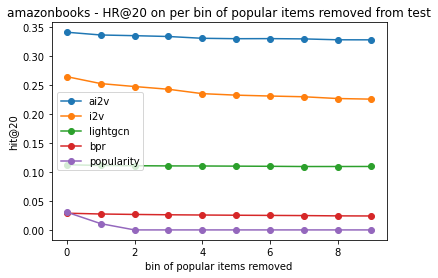

In [35]:
number_of_bins = 10
for hits_file, label in zip([f'{H_FOLD}/{AI2V_OUT_FOLD}/hr_{k}.csv',
                             f'{H_FOLD}/{I2V_OUT_FOLD}/hr_{k}.csv', 
                             f'{H_FOLD}/{LGCN_OUT_FOLD}/hr_{k}.csv',
                             f'{H_FOLD}/{BPR_OUT_FOLD}/hr_{k}.csv',
#                              f'{H_FOLD}/{NCF_OUT_FOLD}/hr_{k}.csv',
                             f'{H_FOLD}/output/pop_model_hr_{k}.csv'],
#                             ['ai2v','i2v','lightgcn','bpr','ncf','popularity']):
                            ['ai2v','i2v','lightgcn','bpr','popularity']):
    hits = pd.read_csv(hits_file, usecols=[0,1,2,3], skiprows=1, names=['user','item','pred_loc','hit'])
    hit_ratios = []
    for bin_ in binned_items[:number_of_bins]:
        new_test = hits[~hits['item'].isin(bin_)]
        if not new_test.empty:
            hit_ratios.append(new_test[new_test['hit']==1].shape[0] / new_test.shape[0])
        else:
            hit_ratios.append(0)
    plt.plot([i for i in list(range(number_of_bins))], hit_ratios,'-o', label=label)
plt.xlabel('bin of popular items removed')
plt.ylabel(f'hit@{k}')
plt.title(f'{DATASET} - HR@{k} on per bin of popular items removed from test')
plt.legend()

# Attention Scores

In [287]:
hits_ai2v = pd.read_csv(f'{H_FOLD}/{AI2V_OUT_FOLD}/hr_{k}.csv', usecols=[0,1,2,3], skiprows=1, names=['user','item','pred_loc','hit'])

In [303]:
hits_ai2v[hits_ai2v['hit']==1].head(100)

,user,item,pred_loc,hit
26,27,1204,11.0,1
38,39,3114,8.0,1
42,43,3114,17.0,1
45,46,1261,19.0,1
53,55,356,19.0,1
...,...,...,...,...
1132,1185,318,6.0,1
1144,1198,1198,8.0,1
1147,1201,1617,17.0,1
1159,1213,1219,8.0,1


In [245]:
test_data = pickle.load(open(f'{H_FOLD}/{DATA_FOLD}/test.dat','rb'))
item2idx = pickle.load(open(f'{H_FOLD}/{DATA_FOLD}/item2idx.dat','rb'))
idx2item = {v:k for k,v in item2idx.items()}
test_orig = []
for tup in test_data:
    target = int(idx2item[tup[1]])
    context = [int(idx2item[idx]) for idx in tup[0]]
    test_orig.append((context, target))
movies = pd.read_csv(f'{H_FOLD}/{DATA_FOLD}/movies.csv')
movies_test = []
for tup in test_orig:
    target = movies.loc[movies['id']==tup[1],'name'].values[0]
    context = [movies.loc[movies['id']==idx,'name'].values[0] 
              for idx in tup[0]]
    movies_test.append((context, target))

In [247]:
attention_score = pickle.load(open(f'{H_FOLD}/{AI2V_OUT_FOLD}/attention_scores.pkl','rb'))

In [ ]:
53

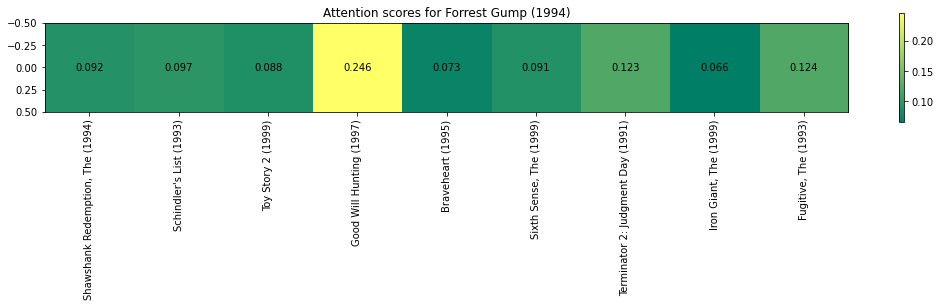

In [305]:
# plt.imshow(arr)
sample = 53
data = np.expand_dims(attention_score[sample], axis=0)
labels = movies_test[sample][0]
target = movies_test[sample][1]


cmap = plt.cm.summer
norm = plt.Normalize(data.min(), data.max())
rgba = cmap(norm(data))

fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(rgba, interpolation='nearest')

im = ax.imshow(data, visible=False, cmap=cmap)

ax.set_xticks(list(range(data.shape[1])))

ax.set_xticklabels(labels, rotation = 90)

for i in range(data.shape[1]):
    text = ax.text(i, 0, round(data[0, i],3),
                       ha="center", va="center")

fig.colorbar(im)
plt.title(f'Attention scores for {target}')
plt.show()

Text(0.5, 1.0, 'Attention scores for Pocahontas (1995)')

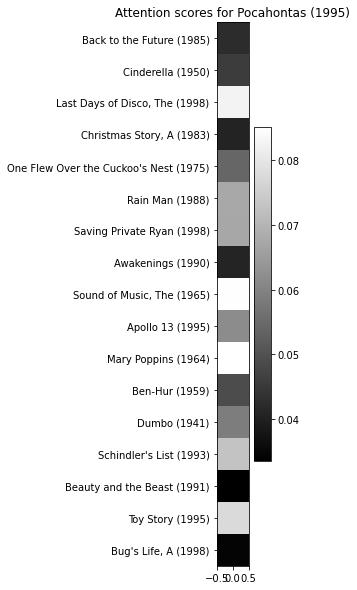

In [263]:
# plt.imshow(arr)
data = np.expand_dims(attention_score[0], axis=1)
labels = movies_test[0][0]
target = movies_test[0][1]


cmap = plt.cm.gray
norm = plt.Normalize(data.min(), data.max())
rgba = cmap(norm(data))

fig, ax = plt.subplots(figsize=(2, 10))
ax.imshow(rgba, interpolation='nearest')

im = ax.imshow(data, visible=False, cmap=cmap)

ax.set_yticks(list(range(data.shape[0])))

ax.set_yticklabels(labels)

fig.colorbar(im)
plt.title(f'Attention scores for {target}')